### *Brainhack Rome 2025*


---



## **Dynamic Brain State Signatures of Psychopathology: A Hidden Markov Modeling Approach**



---


*Project lead:* Federico Calesella, Luca Taffarello, Marco Zenari

*Project contributors:*

In [ ]:
# Install Dynamax for fitting HMMs; require compatibles versions of JAX, NumPy
! pip install numpy==1.24.4
! pip install h5py==3.8.0
! pip install pandas==1.5.3
! pip install scikit-learn==1.2.2
! pip install jax[cpu]==0.4.20  # Use jax[cuda] if you have a GPU
! pip install matplotlib
! pip install git+https://github.com/probml/dynamax

In [ ]:
# Import the needeed libraries
import os
import glob
import h5py
import pandas as pd
from functools import reduce

import jax.numpy as jnp
import jax.random as jr
from dynamax.hidden_markov_model import GaussianHMM, DiagonalGaussianHMM

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

## **Downloading the data**

In [ ]:
# Collect the data
! pip install awscli
! aws s3 sync --no-sign-request s3://openneuro.org/ds005237 ./data \
  --exclude "*" \
  --include "fMRI_timeseries_clean_denoised_GSR_parcellated/*/*" \
  --include "motion_FD/*" \
  --include "phenotype/*"

## **Utils**

In [4]:
# Functions

def load_fmri(data_root, file_pattern):
    data = []
    subjects = []
    folders = sorted([
        f for f in os.listdir(data_root)
        if os.path.isdir(os.path.join(data_root, f))
    ])

    for folder in folders:
        matched_files = glob.glob(os.path.join(data_root, folder, file_pattern))
        if not matched_files:
            print(f"No files found matching {file_pattern} in {folder}")
            continue

        for file_path in matched_files:
            try:
                with h5py.File(file_path, 'r') as hdf:
                    data.append(hdf["dataset"][:])
                    subjects.append(folder)
            except Exception as e:
                print(f"Error loading {file_path}: {str(e)}")

    return data, subjects


def plot_signals(x, dt=1, n_plot=10, n_parcels=None, title=None, figsize=(10,5)):
    '''
    Plot the trajectory of a signal over time
    ---------------------------------------------- PARAMETERS ----------------------------------------------
    x (ndarray): 2D array (time_steps x n_parcels) representing the trajectory of the signal
    dt (float): Time step used in the simulation
    num_trajectories (int): Number of trajectories to randomly select for plotting
    time_steps (int): Total number of time steps in the simulation
    n_parcels (int): Total number of parcels in the simulation
    --------------------------------------------------------------------------------------------------------
    '''
    time_steps = x.shape[0]
    n_parcels = x.shape[1]

    # Generate the time array
    time = np.arange(0, time_steps * dt, dt)

    # Select random trajectories to plot
    random_indices = np.random.choice(n_parcels, size=n_plot, replace=False)
    selected_trajectories = x[:, random_indices]

    # Create the plot
    plt.figure(figsize=figsize)
    plt.plot(time, selected_trajectories, lw=1.5)
    plt.title(title, fontsize=14)
    plt.xlabel('Time', fontsize=13)
    plt.ylabel('x(t)', fontsize=13)
    plt.yticks([np.round(np.max(selected_trajectories), 0), 0, np.round(np.min(selected_trajectories), 0)])

    # Customize the plot
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.tight_layout()


def compute_fc(signal):
    '''
    Evaluate the functional connectivity from a (BOLD) signal.
    ---------------------------------------------- PARAMETERS ----------------------------------------------
    signal (ndarray): A 2D array representing the BOLD signal (n_parc x time_steps)
    --------------------------------------------------------------------------------------------------------
    Returns:
    - fc (ndarray): A 2D array containing the functional connectivity matrix
    '''
    fc = np.corrcoef(signal)
    return fc


def get_fcd(signal, win_len=25, win_sp=1):
    '''
    Evaluate dynamic functional connectivity from a (BOLD) signal with sliding window approach
    '''
    signal = signal.T
    n_samples, n_nodes = signal.shape
    fc_triu_ids = np.triu_indices(n_nodes, 1)

    fc_stack = []
    fc_prev = None

    for t0 in range(0, n_samples - win_len, win_sp):
        t1 = t0 + win_len
        fc = np.corrcoef(signal[t0:t1, :].T)[fc_triu_ids]
        fc_stack.append(fc)
        fc_prev = fc if fc_prev is None else fc_prev

    fcs = np.array(fc_stack)
    fcd = np.corrcoef(fcs)

    return fcd


def compute_pca(signal, n_components=None):
    '''
    Compute the PCA of a given signal
    ---------------------------------------------- PARAMETERS ----------------------------------------------
    - signal (ndarray): The input signal, shape (n_samples, n_features)
    - n_components (int or None): Number of principal components to keep. If None, all components are kept
    --------------------------------------------------------------------------------------------------------
    Returns:
    - pca_components (ndarray): The principal components of the signal
    - explained_variance_ratio (ndarray): The variance explained by each principal component
    '''
    # Initialize PCA
    pca = PCA(n_components=n_components)

    # Fit and transform the signal
    projections = pca.fit_transform(signal)

    # Get explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_

    # eigenvectors
    eigenvectors = pca.components_

    return projections, explained_variance_ratio, eigenvectors


## Giving a look at the data

In [5]:
data, sub = load_fmri("./data/fMRI_timeseries_clean_denoised_GSR_parcellated", "task-rest*.h5")
data = np.array( [array for array in data if array.shape[1]==488] )  # Filter the data for subject that completed the task
#NB: 488 is the number of time-points of a complete acquisition for task rest

#performing z-scores of the data
bold_data_zsc = np.array([
        (bold_sub - np.mean(bold_sub, axis=1, keepdims=True)) / np.std(bold_sub, axis=1, keepdims=True)
        for bold_sub in data
    ])

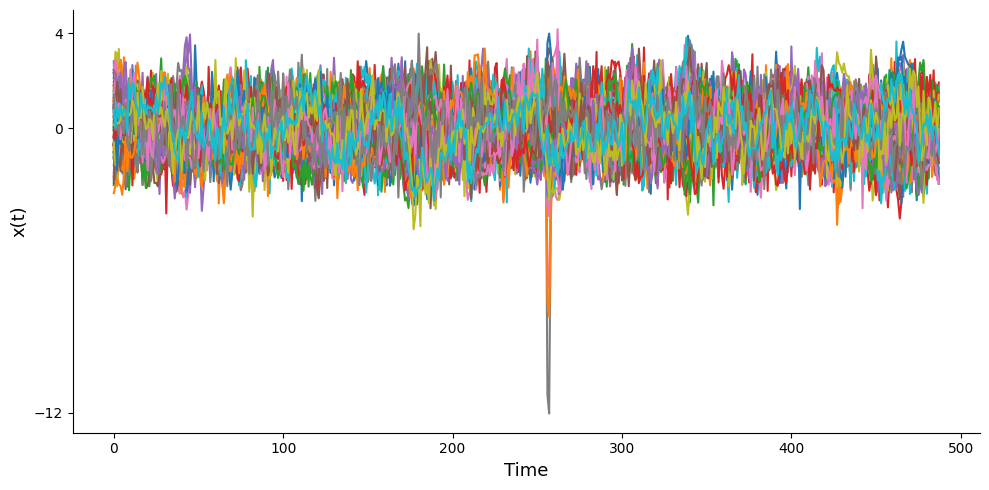

In [7]:
#example of zscore signal
plot_signals(bold_data_zsc[0].T, n_plot=100)

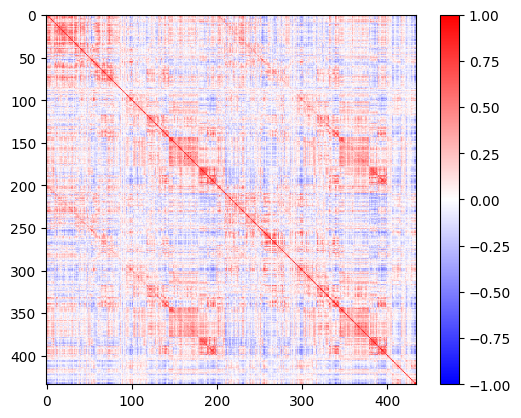

In [8]:
#plot example of Functional Connetivity (FC)
fc = compute_fc(bold_data_zsc[0])
plt.imshow(fc, cmap='bwr', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

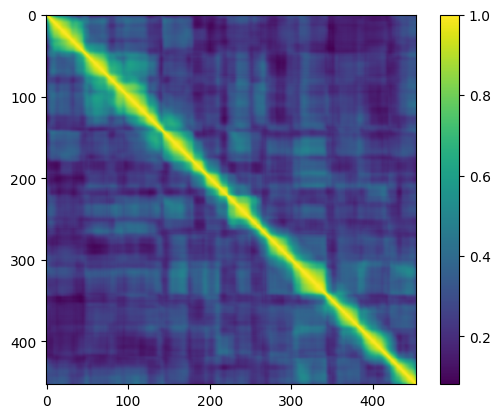

In [9]:
#dynamical functional connectivity (fcd)
fcd = get_fcd(bold_data_zsc[0], win_len=35, win_sp=1)
plt.imshow(fcd, cmap='viridis')
plt.colorbar()
plt.show()

## **Preparing the data for HMM - PCA**

In [11]:
data_hmm = np.concatenate(bold_data_zsc, axis=1)

'''
n_subj, n_components, n_timesteps = data.shape

# Create an array of NaNs for the extra timestep
nan_timestep = np.full((n_subj, n_components, 1), np.nan)

# Concatenate the NaNs to the end of each subject's time series
data_with_nan = np.concatenate([bold_data_zsc, nan_timestep], axis=2)

# Concatenate the subjects
data_hmm_nan = np.concatenate(data_with_nan, axis=1)
'''

data_hmm.shape

(434, 462624)

In [12]:
proj, expl_var, eigvects = compute_pca(data_hmm.T, n_components=100)

## **HMM fit**

In [ ]:
key1, key2 = jr.split(jr.PRNGKey(0), 2)
num_states = 10
emission_dim = proj.shape[1]
num_timesteps = proj.shape[0]

# Make a Gaussian HMM and sample data from it
hmm = DiagonalGaussianHMM(num_states, emission_dim)
true_params, _ = hmm.initialize(key1)
#true_states, emissions = hmm.sample(true_params, key2, num_timesteps)
emissions = proj

# Make a new Gaussian HMM and fit it with EM
params, props = hmm.initialize(key2, method="kmeans", emissions=emissions)
params, lls = hmm.fit_em(params, props, emissions, num_iters=10)

# Plot the marginal log probs across EM iterations
plt.plot(lls)
plt.xlabel("EM iterations")
plt.ylabel("marginal log prob.")

# Use fitted model for posterior inference
post = hmm.smoother(params, emissions)
print(post.smoothed_probs.shape) # (1000, 3)
